# Moving MNIST
> How to use fastai to predict the movement of numbers

- toc: true 
- badges: true
- comments: true
- categories: [Pytorch, fastai, cv]
- author: Thomas Capelle
- image: images/moving_mnist.png

![Segmentation](../images/moving_mnist.png)

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

  Using cached rarfile-4.0-py3-none-any.whl (28 kB)
  Using cached av-8.0.3-cp38-cp38-manylinux2010_x86_64.whl (38.1 MB)


This tutorial uses fastai to process sequences of images. In this problem, the model has to predict the future frames of a sequence. We will solve a toy example where MNIST digits are moving on a canvas. This is an `ImageTuple` to `ImageTuple` task.
- First we will construct a moving MNIST dataset.
- We will train a simple model to forecast the movent of numbers
- Finally we will try to make a "SOTA" model work

In [3]:
from fastai.vision.all import *

## Building Moving MNIST 
> from MNIST

We are going to construct the dataset starting from the MNIST dataset available from fastai.

In [9]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/tcapelle/.fastai/data/mnist_png/training'),Path('/home/tcapelle/.fastai/data/mnist_png/testing')]

MNIST files are split in a `training` and `testing` folder. We will use the trianing one for our experiments.

In [15]:
files = get_image_files(path/'training')
files

(#60000) [Path('/home/tcapelle/.fastai/data/mnist_png/training/6/30582.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/41995.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/1830.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/53900.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/51920.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/17867.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/59601.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/1768.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/4560.png'),Path('/home/tcapelle/.fastai/data/mnist_png/training/6/35616.png')...]

we can look at the first image: 

In [21]:
img = load_image(files[0])
img

In [22]:
img.shape

(28, 28)

We will define some constants to work with.
- `digit_size`: is the resolution of the MNIST images (28x28)
- `image_size`: is the canvas size (64x64)
- `step_length`: is the "speed" of the moving digits on the canvas

In [25]:
digit_size = 28
image_size = 64
step_length = 0.2
N = len(files)

we first have to create random trayectories of the (28x28) digits on the canvas, we will make them bounce back when they hit a border. We will compute the trayectory of the corner of the digit.

In [26]:
def get_random_trajectory(seq_length):
    "Generate a trajectory"
    canvas_size = image_size - digit_size
    x, y, v_x, v_y = np.random.random(4)
    out_x, out_y = [], []
    
    for i in range(seq_length):
        # Take a step along velocity.
        y += v_y * step_length
        x += v_x * step_length

        # Bounce off edges.
        if x <= 0:
            x = 0
            v_x = -v_x
        if x >= 1.0:
            x = 1.0
            v_x = -v_x
        if y <= 0:
            y = 0
            v_y = -v_y
        if y >= 1.0:
            y = 1.0
            v_y = -v_y
        out_x.append(x * canvas_size)
        out_y.append(y * canvas_size)

    return tensor(out_x, dtype=torch.uint8), tensor(out_y, dtype=torch.uint8)

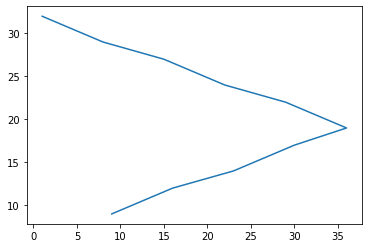

In [27]:
x,y = get_random_trajectory(10)
plt.plot(x,y)

let's grab a random image from the dataset

In [28]:
from random import choice
def get_rand_img():
    "Get one digit randomly"
    img = load_image(choice(files))
    return TensorImage(img)

we will directly convert to a tensor, to work on the canvas.

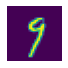

In [29]:
timg = get_rand_img()
timg.show();

to move the digit, we get one randomly and shift using the random trayectory.

In [30]:
def generate_moving_digit(n_frames, image_size=64):
    "Move one digit on the canvas"
    digit_image = get_rand_img()
    xs, ys = get_random_trajectory(n_frames)
    canvas = torch.zeros((n_frames, 1, image_size, image_size), dtype=torch.uint8)
    for i,(x,y) in enumerate(zip(xs,ys)):
        canvas[i, 0, y:(y+digit_size),x:(x+digit_size)] = digit_image
    return canvas

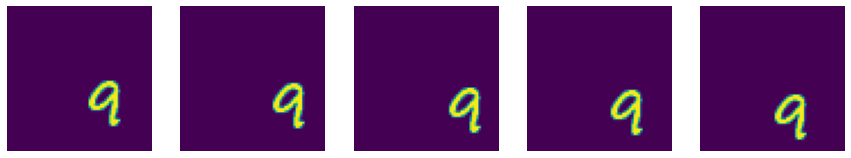

In [31]:
show_images(generate_moving_digit(5))

we can combine multiple digits with different trayectories at once.

In [32]:
def generate_moving_digits(n_frames, digits=1):
    "generate multiple digits"
    return torch.stack([generate_moving_digit(n_frames) for n in range(digits)]).max(dim=0)[0]

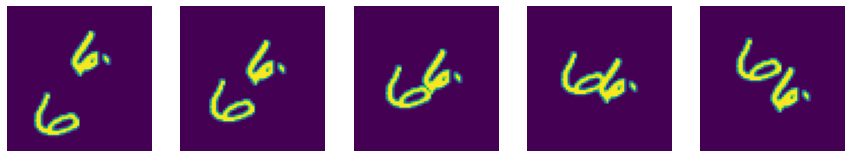

In [33]:
digits = generate_moving_digits(5, 2)
show_images(digits)

We are going to use the mid level APi, but as we already have a tensor, is very simple.

In [34]:
class ImageSeq(fastuple):
    @classmethod
    def create(cls, t, cl_type=TensorImageBW):
        return cls(tuple(cl_type(im) for im in t))
    def show(self, ctx=None, **kwargs): 
        return show_image(torch.cat([t for t in self], dim=-1), ctx=ctx, **self[0]._show_args, figsize=(10,5), **kwargs)

In [35]:
img_seq = ImageSeq.create(digits)

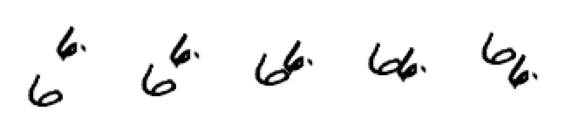

In [36]:
img_seq.show();

we will create a simple function to split our sequence on (x,y) where the first `n_in` frames will serve as input and the last `n_out` frames as target.

In [37]:
def get_items(n_in=3, n_out=3, n_digits=2):
    n_frames = n_in + n_out
    digits = generate_moving_digits(n_frames, n_digits)
    x, y = digits[0:n_in], digits[n_in:]
    return x, y

In [38]:
class ImageSeqTransform(Transform):
    def __init__(self, n_in, n_out, n_digits=2, cl_type=TensorImageBW):
        store_attr()
        
    def encodes(self, idx):
        x, y = get_items(self.n_in, self.n_out, self.n_digits)
        return ImageSeq.create(x, self.cl_type), ImageSeq.create(y, self.cl_type)

as the images are generated on the fly, we pass a list of integers to the `TfmdLists` constructor that will only serve as a counting mechanism.

In [39]:
idxs = range_of(10)
splits = [0,1,2,3,4,5,6,7], [8,9]

In [40]:
tls = TfmdLists(idxs, ImageSeqTransform(3,3), splits=splits)

we will put everything together into a `DataLoaders` object, and we are ready to train.

In [44]:
dls = tls.dataloaders(bs=4, after_batch=[IntToFloatTensor, Normalize.from_stats(*mnist_stats)])

as we can see with `one_batch` and `explode_types`, we get 3 images as input, and 3 as output

In [45]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {__main__.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

In [46]:
b[0][0].shape

torch.Size([4, 1, 64, 64])

## Refactor 
> Let's put everything together to train with a large dataset

In [47]:
def get_dls(n_in, n_out, N=100, bs=4):
    idxs = range_of(N)
    splits = RandomSplitter()(idxs)
    tls = TfmdLists(idxs, ImageSeqTransform(n_in, n_out), splits=splits)
    return tls.dataloaders(bs=bs, after_batch=[IntToFloatTensor, Normalize.from_stats(*mnist_stats)])

In [48]:
dls = get_dls(3, 3, N=1000, bs=4)

we have to make a custom `show_batch` method using the `@typedispatch` decorator to be able to show our `ImageSeq` objects.

In [49]:
@typedispatch
def show_batch(x:ImageSeq, y:ImageSeq, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n* 1.2)
    if ctxs is None: 
        _, ctxs = plt.subplots(min(x[0].shape[0], max_n), ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        samples[i][0].show(ctx=ctx[0]), samples[i][1].show(ctx=ctx[1])

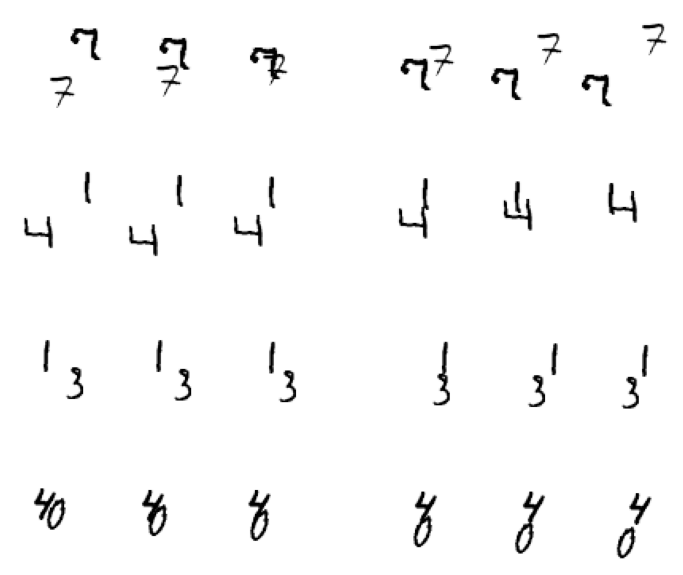

In [50]:
dls.show_batch()

## How to build a Model for this task?
> Trying something simple

As we saw before, the batch is composed of an `ImageSeq` as input and an `ImageSeq` as output, so we need a model capable of processing this. Let's build something super simple.
- We already have an image to image fastai model called `DyanmicUnet`
- This model takes one image, and produces another one.
- The simplest model would not have temporal capabilities, and only process one image at a time. You encode the first image and decode the first target.

In [61]:
x,y = dls.one_batch()

In [62]:
class SimpleModel(Module):
    def __init__(self, arch=resnet34):
        encoder = create_body(arch, n_in=1)
        self.unet = DynamicUnet(encoder, n_out=1, img_size=(64, 64))
        
    def forward(self, image_seq):
        return [self.unet(img) for img in image_seq]

In [67]:
model = SimpleModel().cuda()

In [69]:
out = model(x)
out[0].shape

torch.Size([4, 1, 64, 64])

In [73]:
class SeqLoss:
    def __init__(self, loss_func):
        self.loss_func = loss_func
    def __call__(self, inp_seq, targ_seq):
        return sum([self.loss_func(inp, tar) for inp, tar in zip(inp_seq, targ_seq)])

In [76]:
loss_func = SeqLoss(MSELossFlat())

In [77]:
loss_func(out, y)

TensorBase(1.6183, device='cuda:0', grad_fn=<AliasBackward>)

In [79]:
learn = Learner(dls, model, loss_func=loss_func)

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=7.585775847473997e-07)

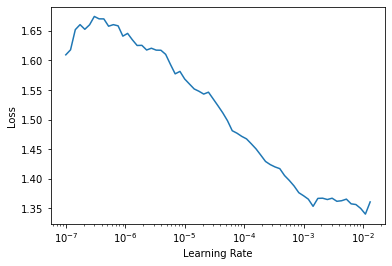

In [80]:
learn.lr_find()

In [81]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,time
0,1.112344,1.067903,00:15
1,1.034838,1.020462,00:15
2,1.028217,1.004328,00:15
3,1.018567,1.035076,00:15


In [84]:
p,t = learn.get_preds()

As you can see, the results is a list of 3 tensors with 200 samples each.

In [95]:
len(p), p[0].shape

(3, torch.Size([200, 1, 64, 64]))

In [96]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(3)])
    im_seq.show();

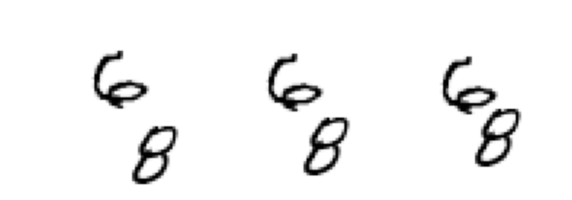

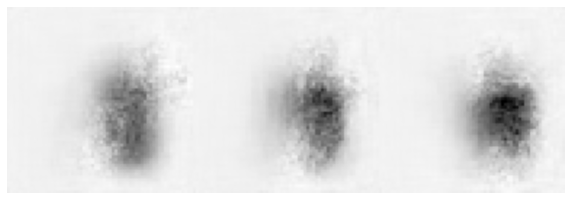

In [97]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)